### Library Import

In [2]:
import os
from typing import List, Dict
from tqdm import tqdm
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### Data Load

In [4]:
# 파일 호출
data_path: str = "../data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
initial_df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [5]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    initial_df = initial_df.merge(_df, on="ID", how="left")


100%|██████████| 107/107 [00:04<00:00, 26.34it/s]


### 결측치 확인
받은 데이터상에서 결측치는 없어 보이나,
위 df는 2023.01.01~2024.04.26까지만의 데이터로 left join 하였으므로 이에 따른 결측치가 발생한다.

이때 train data에서는 결측치가 100%가 아니더라도 test data에서 100%의 결측치가 발생할 수 있음을 확인하였다

이는 곧 train data에서 사용하더라도 test data로 예측 시 사용할 수 없는 feature이므로, 해당 feature들을 제거하고 학습할 필요가 있다

In [75]:
eda_train_df = initial_df.loc[initial_df["_type"] == "train"]
# 각 열에서 누락된 값의 수를 계산
missing_values = eda_train_df.isnull().sum()

# 누락된 값의 백분율 계산
missing_percentage = (missing_values / len(eda_train_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)
sorted_missing_percentage

hourly_market-data_liquidations_okex_btc_usd_long_liquidations_usd            100.0
hourly_market-data_open-interest_ftx_open_interest                            100.0
hourly_market-data_open-interest_ftx_btc_usd_open_interest                    100.0
hourly_market-data_taker-buy-sell-stats_okex_taker_sell_volume                100.0
hourly_market-data_taker-buy-sell-stats_okex_taker_buy_ratio                  100.0
                                                                              ...  
hourly_market-data_liquidations_htx_global_btc_usdt_short_liquidations_usd      0.0
hourly_market-data_liquidations_htx_global_btc_usdt_long_liquidations_usd       0.0
hourly_market-data_liquidations_htx_global_btc_usdt_short_liquidations          0.0
hourly_market-data_liquidations_htx_global_btc_usdt_long_liquidations           0.0
hourly_network-data_velocity_velocity_supply_total                              0.0
Length: 255, dtype: float64

In [91]:
sorted_missing_percentage.value_counts().sort_values(ascending=False)
# sorted_missing_percentage[sorted_missing_percentage > 10].shape

0.011416      70
0.000000      55
100.000000    40
0.079909      25
0.091324      20
0.057078      12
0.216895      10
1.004566       5
0.342466       5
0.068493       5
0.034247       5
0.353881       1
0.136986       1
0.045662       1
Name: count, dtype: int64

In [4]:
eda_test_df = initial_df.loc[initial_df["_type"] == "test"]
# 각 열에서 누락된 값의 수를 계산
test_missing_values = eda_test_df.isnull().sum()

# 누락된 값의 백분율 계산
test_missing_percentage = (test_missing_values / len(eda_test_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
test_sorted_missing_percentage = test_missing_percentage.sort_values(ascending=False)
test_sorted_missing_percentage

hourly_market-data_open-interest_binance_open_interest                        100.0
hourly_market-data_open-interest_all_exchange_open_interest                   100.0
hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume               100.0
hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close                100.0
hourly_market-data_liquidations_okex_all_symbol_short_liquidations            100.0
                                                                              ...  
hourly_market-data_liquidations_okx_all_symbol_long_liquidations                0.0
hourly_market-data_liquidations_htx_global_btc_usdt_short_liquidations_usd      0.0
hourly_market-data_liquidations_htx_global_btc_usdt_long_liquidations_usd       0.0
hourly_market-data_liquidations_htx_global_btc_usdt_short_liquidations          0.0
hourly_network-data_velocity_velocity_supply_total                              0.0
Length: 255, dtype: float64

In [92]:
test_sorted_missing_percentage.value_counts().sort_values(ascending=False)

0.000000      56
100.000000    48
0.143266      22
0.071633      21
1.038682      13
0.179083      13
1.146132      13
1.110315      12
0.035817      11
1.002865       6
1.719198       5
1.074499       5
0.107450       5
3.617479       4
0.895415       4
0.214900       4
1.862464       4
5.336676       4
18.230659      1
0.322350       1
1.181948       1
1.253582       1
1.790831       1
Name: count, dtype: int64

In [99]:
print(test_sorted_missing_percentage[test_sorted_missing_percentage > 50])
print(test_sorted_missing_percentage[test_sorted_missing_percentage > 50].shape)

hourly_market-data_open-interest_binance_open_interest                     100.0
hourly_market-data_open-interest_all_exchange_open_interest                100.0
hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume            100.0
hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close             100.0
hourly_market-data_liquidations_okex_all_symbol_short_liquidations         100.0
hourly_market-data_liquidations_okex_all_symbol_long_liquidations          100.0
hourly_market-data_open-interest_okx_open_interest                         100.0
hourly_market-data_open-interest_okex_open_interest                        100.0
hourly_market-data_open-interest_bitmex_open_interest                      100.0
hourly_market-data_open-interest_kraken_open_interest                      100.0
hourly_market-data_open-interest_bybit_open_interest                       100.0
hourly_market-data_taker-buy-sell-stats_okex_taker_buy_volume              100.0
hourly_market-data_open-inte

In [112]:
print(test_sorted_missing_percentage[test_sorted_missing_percentage == 0])
print(test_sorted_missing_percentage[test_sorted_missing_percentage == 0].shape)

hourly_network-data_addresses-count_addresses_count_receiver                      0.0
hourly_network-data_addresses-count_addresses_count_sender                        0.0
hourly_network-data_tokens-transferred_tokens_transferred_total                   0.0
hourly_network-data_addresses-count_addresses_count_active                        0.0
hourly_network-data_tokens-transferred_tokens_transferred_median                  0.0
hourly_network-data_hashrate_hashrate                                             0.0
hourly_network-data_blockreward_blockreward                                       0.0
hourly_network-data_blockreward_blockreward_usd                                   0.0
hourly_network-data_fees-transaction_fees_transaction_median                      0.0
hourly_network-data_fees-transaction_fees_transaction_median_usd                  0.0
hourly_network-data_fees_fees_total_usd                                           0.0
hourly_network-data_fees_fees_total                   

In [94]:
for col in test_sorted_missing_percentage[test_sorted_missing_percentage > 50].index:
    if col not in missing_percentage[missing_percentage > 50].index:
        print(col)

hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume
hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close
hourly_market-data_liquidations_binance_btc_busd_long_liquidations
hourly_market-data_liquidations_binance_btc_busd_short_liquidations
hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd
hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd
target
hourly_market-data_open-interest_binance_btc_busd_open_interest


In [93]:
for col in sorted_missing_percentage[sorted_missing_percentage > 50].index:
    if col not in test_missing_percentage[test_missing_percentage > 50].index:
        print(col)

**결론**


관측 결과 train에서 결측치가 100%고 test에서 결측치가 100%가 아닌 경우는 없으나, 

test에서 결측치가 100%고 train에서 결측치가 100%가 아닌 feature가 target column을 제외하면 7개가 관측된다.

따라서 test data에서 결측치가 100%인 feature들만 제거해주고 학습하면 된다 (target column은 빼면 안된다!)

In [5]:
# 아래 코드만 돌려서 누락된 값이 50% 이상인 열을 제거

eda_test_df = initial_df.loc[initial_df["_type"] == "test"]
# 각 열에서 누락된 값의 수를 계산
test_missing_values = eda_test_df.isnull().sum()

# 누락된 값의 백분율 계산
test_missing_percentage = (test_missing_values / len(eda_test_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
test_sorted_missing_percentage = test_missing_percentage.sort_values(ascending=False)
test_sorted_missing_percentage

columns_to_drop = test_sorted_missing_percentage[test_sorted_missing_percentage > 50].index
columns_to_drop = columns_to_drop.difference(['target'])  # 'target' 열을 제외

initial_df = initial_df.drop(columns=columns_to_drop)
# initial_df.tail(50)

In [29]:
initial_df.columns.tolist()

['ID',
 'target',
 '_type',
 'hourly_market-data_coinbase-premium-index_coinbase_premium_gap',
 'hourly_market-data_coinbase-premium-index_coinbase_premium_index',
 'hourly_market-data_funding-rates_all_exchange_funding_rates',
 'hourly_market-data_funding-rates_binance_funding_rates',
 'hourly_market-data_funding-rates_bitmex_funding_rates',
 'hourly_market-data_funding-rates_bybit_funding_rates',
 'hourly_market-data_funding-rates_deribit_funding_rates',
 'hourly_market-data_funding-rates_htx_global_funding_rates',
 'hourly_market-data_funding-rates_huobi_global_funding_rates',
 'hourly_market-data_funding-rates_okx_funding_rates',
 'hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations',
 'hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations',
 'hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd',
 'hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd',
 'hourly_market-data_liquidations_bi

### EDA (Explanatory Data Analysis)

In [23]:
eda_df = initial_df.filter(like="open-interest")

In [24]:
eda_df.reset_index(inplace=True)
df_melted = eda_df.melt(id_vars=['index'], var_name='Column', value_name='Value')

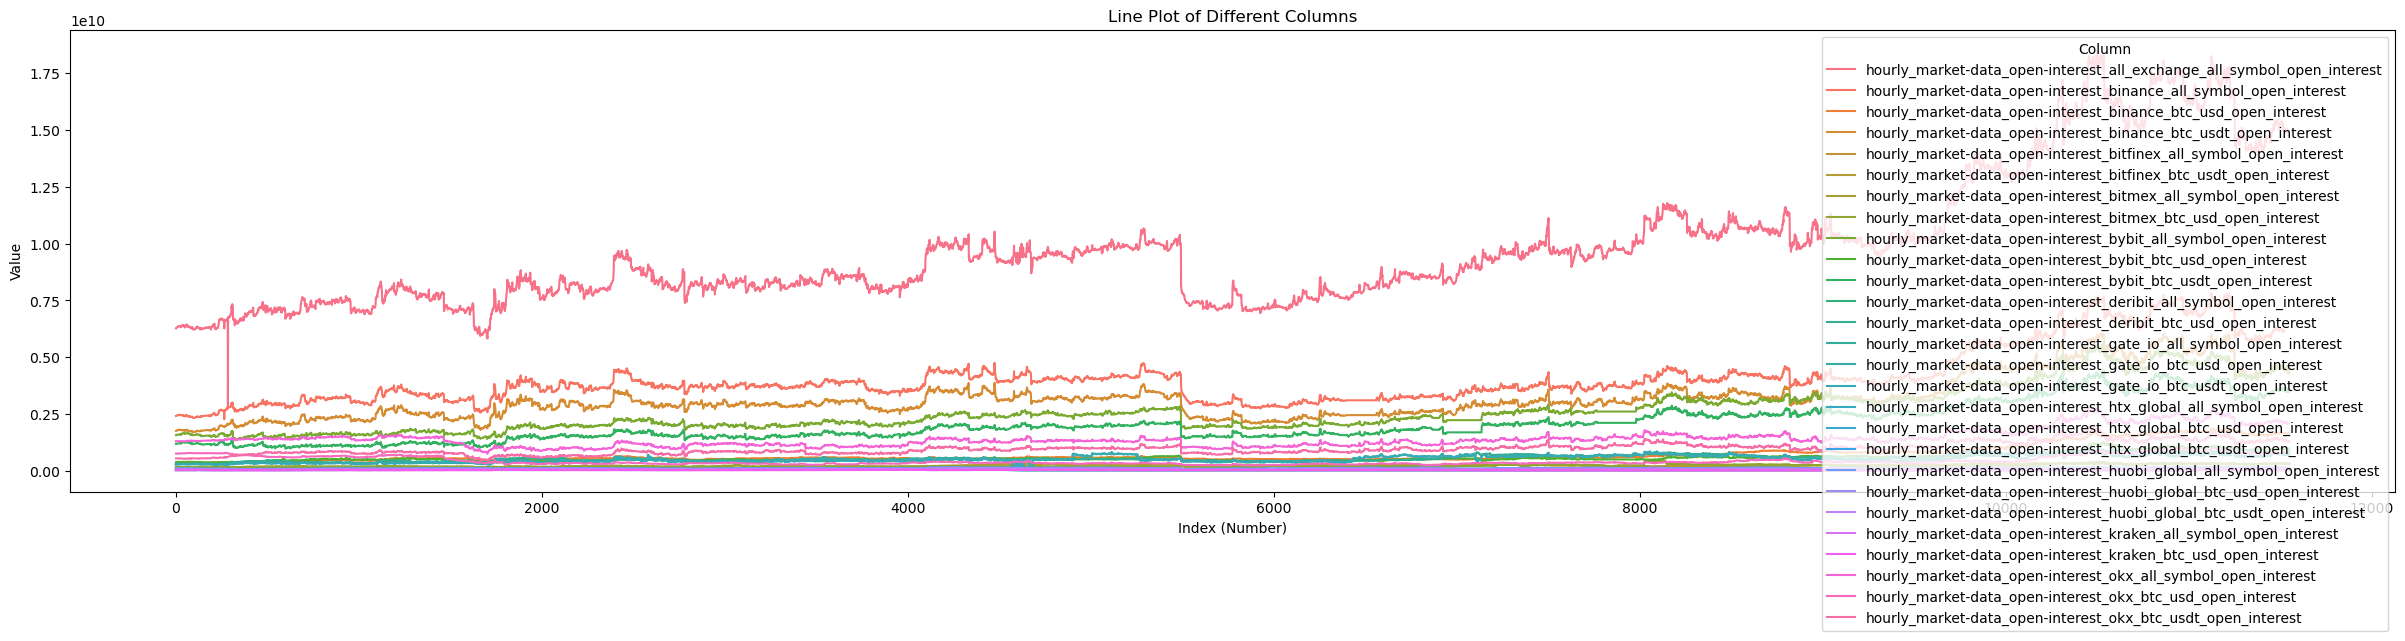

In [26]:
plt.figure(figsize=(30, 6))
sns.lineplot(x='index', y='Value', hue='Column', data=df_melted)

# 그래프 제목과 축 레이블 설정
plt.title('Line Plot of Different Columns')
plt.xlabel('Index (Number)')
plt.ylabel('Value')

plt.show()

**결론**
: hourly_market-data_open-interest_all_exchange_all_symbol_open_interest 만 쓰기

In [18]:
eda_df = initial_df.filter(like='btc_usd_close', axis=1)

In [19]:
eda_df.reset_index(inplace=True)
df_melted = eda_df.melt(id_vars=['index'], var_name='Column', value_name='Value')

In [922]:
eda_df.head()

,index,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close
0,0,16536.747967
1,1,16557.136536
2,2,16548.149805
3,3,16533.632875
4,4,16524.712159


In [919]:
df_melted.head()

,index,Column,Value
0,0,hourly_market-data_price-ohlcv_all_exchange_sp...,16536.747967
1,1,hourly_market-data_price-ohlcv_all_exchange_sp...,16557.136536
2,2,hourly_market-data_price-ohlcv_all_exchange_sp...,16548.149805
3,3,hourly_market-data_price-ohlcv_all_exchange_sp...,16533.632875
4,4,hourly_market-data_price-ohlcv_all_exchange_sp...,16524.712159


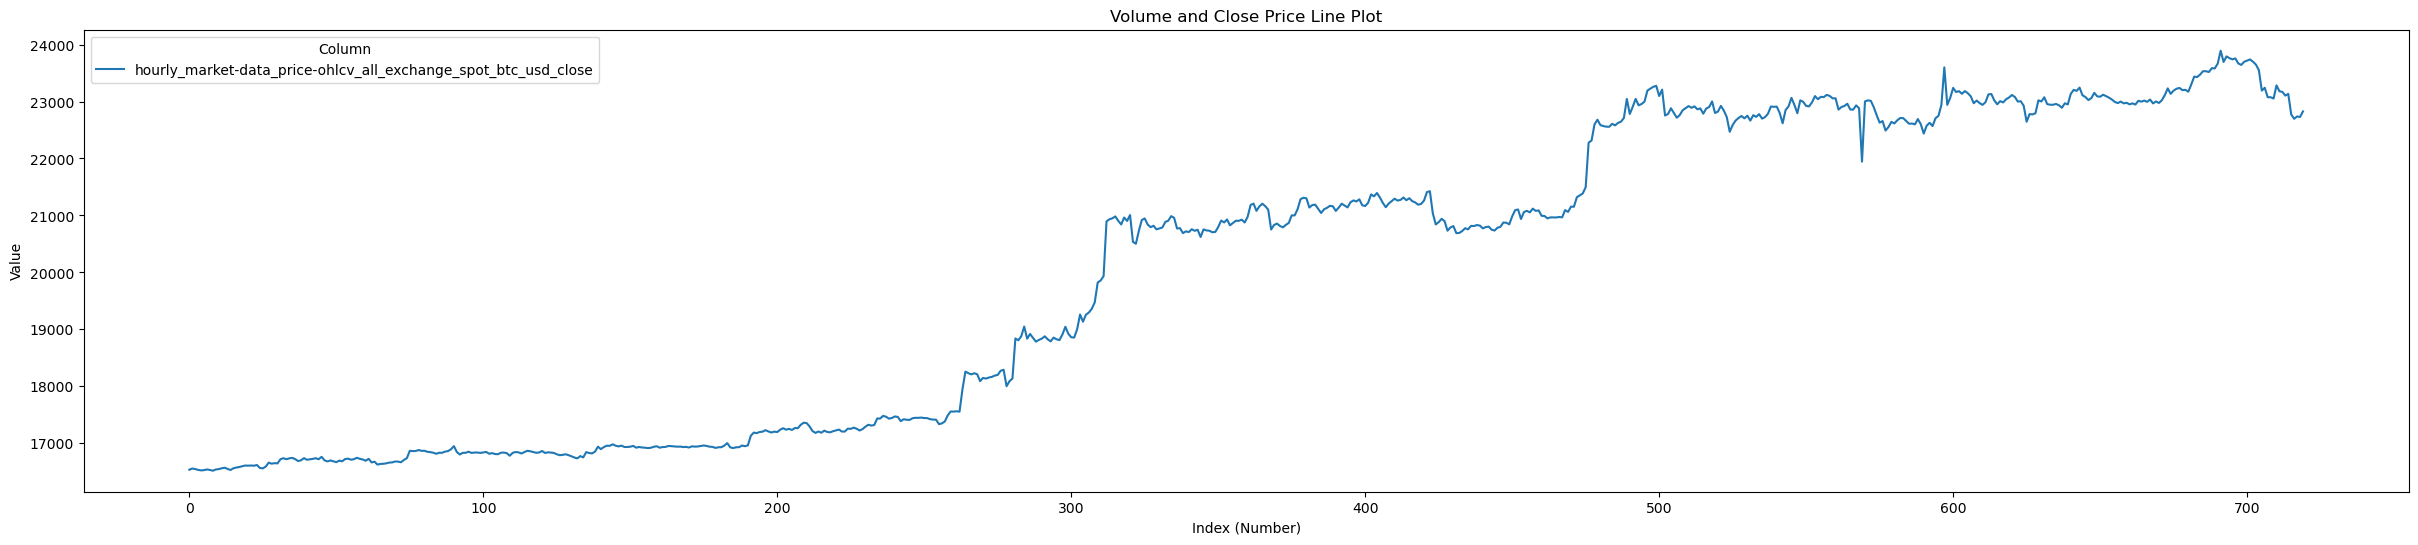

In [331]:
plt.figure(figsize=(30, 6))
sns.lineplot(x='index', y='Value', hue='Column', data=df_melted[:30*24])

# 그래프 제목과 축 레이블 설정
plt.title('Volume and Close Price Line Plot')
plt.xlabel('Index (Number)')
plt.ylabel('Value')

plt.show()

### Feature Engineering

In [1099]:
# 모델에 사용할 컬럼, 컬럼의 rename rule을 미리 할당함
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "buy_sell_ratio",
    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close": "close",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
    "hourly_network-data_addresses-count_addresses_count_active": "active_count",
    "hourly_network-data_addresses-count_addresses_count_receiver": "receiver_count",
    
}

conti_cols: List[str] = [_ for _ in cols_dict.values() if _ not in ["ID", "target", "_type", "close"]]
df = initial_df[cols_dict.keys()].rename(cols_dict, axis=1)
df.shape

(11552, 12)

In [1100]:
shift_cols = {"sell_volume": 1, "receiver_count": 7, "active_count": 7}
def shift_feature(
    df: pd.DataFrame,
    shift_cols: Dict[str, int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col, interval in shift_cols.items()
    ]
    return df_shift_dict

# 최대 8시간의 shift 피쳐를 계산
shift_list = shift_feature(
    df=df, shift_cols=shift_cols
)

In [1101]:
rolling_cols = [_ for _ in conti_cols if _  not in ["open_interest", "long_liquidations", "short_liquidations"]]
def rolling_feature(df: pd.DataFrame, conti_cols: List[str], window_size: int) -> List[pd.Series]:
    """
    연속형 변수의 rolling feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        window_size (int): rolling window size
    Return:
        List[pd.Series]
    """
    df_rolling_list = [
        df[conti_col].rolling(window=window_size).mean().rename(f"{conti_col}_rolling_mean_{window_size}")
        for conti_col in conti_cols
    ]
    return df_rolling_list

rolling_list = rolling_feature(df=df, conti_cols=conti_cols, window_size=24)

In [1102]:
# concat 하여 df 에 할당
df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)
# df = pd.concat([df, pd.concat(rolling_list, axis=1)], axis=1)
df = df.drop(["active_count", "receiver_count"], axis=1)

# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)

# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

feature_cols_list = [_ for _ in df.columns if _ not in ["ID", "target", "_type", "close"]]

In [1103]:
df.columns.tolist()

['ID',
 'target',
 '_type',
 'long_liquidations',
 'short_liquidations',
 'open_interest',
 'buy_sell_ratio',
 'close',
 'buy_volume',
 'sell_volume',
 'sell_volume_1',
 'receiver_count_7',
 'active_count_7']

### 계산한 class와 실제 class 비교

In [1297]:
classify_weight = 0.1
def classify_change(prev_value, curr_value):
    change_ratio = (curr_value - prev_value) / abs(curr_value)
    if np.isnan(change_ratio) or pd.isna(change_ratio):
        return 2
    if change_ratio > classify_weight:
        return 3  # 큰 상승
    elif change_ratio > 0:
        return 2  # 약간 상승
    elif change_ratio > -classify_weight:
        return 1  # 약간 하락
    else:
        return 0  # 큰 하락

### Model Training

In [1104]:
# 데이터 로더: 데이터프레임을 받아서 train/eval 모드에 따라 (sequence, target) numpy 배열을 반환
def data_loader(df, mode, input_scaler, output_scaler, sequence_length):
    features = df[feature_cols_list].values
    target = df["close"].values
    ground_truth = df["target"].values
    if mode == "train":
        features_scaled = input_scaler.fit_transform(features)
        target_scaled = output_scaler.fit_transform(target.reshape(-1, 1))
    else:
        features_scaled = input_scaler.transform(features)
        target_scaled = output_scaler.transform(target.reshape(-1, 1))
    
    # X: (N, sequence_length, num_features), Y: (N,)
    X, Y = [], []
    for i in range(len(features_scaled)- sequence_length):
        X.append(features_scaled[i:i+sequence_length])
        Y.append(target_scaled[i+sequence_length])
    
    print(f"Number of sequences: {len(X)}")
    
    return np.array(X), np.array(Y), np.array(ground_truth)

In [1105]:
train_seq_len = 8

In [1106]:
# scaler 생성
input_scaler = MinMaxScaler(feature_range=(0, 1))
output_scaler = MinMaxScaler(feature_range=(0, 1))

# train 데이터 로드하기
X_train, y_train, output_train = data_loader(train_df, mode="train", input_scaler=input_scaler, output_scaler=output_scaler, sequence_length=train_seq_len)

Number of sequences: 8752


In [1107]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).squeeze()
output_train_df = pd.DataFrame(output_train, columns=["class"])
direction_train_tensor = np.where((output_train == 0) | (output_train == 1), 0, 1)
direction_train_tensor = torch.tensor(direction_train_tensor, dtype=torch.float32)
direction_train_tensor = direction_train_tensor[train_seq_len:]
print(X_train_tensor.shape)
print(y_train_tensor.shape)

torch.Size([8752, 8, 9])
torch.Size([8752])


In [789]:
def model_prediction(model, X, output_scaler):
    model.eval()
    prediction, _ = model(X)
    prediction = output_scaler.inverse_transform(prediction.detach().numpy())
    prediction_df = pd.DataFrame(prediction)
    print(prediction_df.describe())
    return prediction

def classify_change(prev_value, curr_value):
    change_ratio = (curr_value - prev_value) / abs(curr_value)
    if np.isnan(change_ratio) or pd.isna(change_ratio):
        return 2
    if change_ratio > classify_weight:
        return 3  # 큰 상승
    elif change_ratio > 0:
        return 2  # 약간 상승
    elif change_ratio > -classify_weight:
        return 1  # 약간 하락
    else:
        return 0  # 큰 하락

In [776]:
def model_accuracy(model, X, output, output_scaler, doesPrint=False):
    # 예측하기
    prediction = model_prediction(model, X=X, output_scaler=output_scaler)
    prediction_df = pd.DataFrame(prediction)
    
    # df[0] 데이터 가져오기
    first_value = prediction_df.iloc[0]
    # df[0] 데이터를 8줄로 쌓기
    new_rows = pd.DataFrame([first_value] * train_seq_len, columns=prediction_df.columns)
    # 기존 df 앞에 new_rows 추가
    prediction_df = pd.concat([new_rows, prediction_df], ignore_index=True)

    prediction_df.columns = ["predicted_close"]
    
    # predicted_close로 predicted_class 분류하기
    prediction_df["next_predicted_close"] = prediction_df["predicted_close"].shift(-1)
    prediction_df['predicted_class'] = prediction_df.apply(lambda x: classify_change(x['predicted_close'], x['next_predicted_close']), axis=1)
    final_prediction_df = pd.merge(prediction_df, output, left_index=True, right_index=True, how='inner')
    if doesPrint:
        print(final_prediction_df[["class", "predicted_class"]].value_counts().sort_index())
    
    # accuracy 계산하기
    wrong_prediction = final_prediction_df[final_prediction_df["class"]!=final_prediction_df["predicted_class"]]
    accuracy = 1 - wrong_prediction.shape[0] / output.shape[0]
    return final_prediction_df, accuracy
    

In [1108]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.5):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        
        # 회귀 (가격 예측) 출력을 위한 선형 레이어
        self.price_fc = nn.Linear(hidden_size, 1)  # 코인 가격 출력
        
        # 이진 분류 (등락 예측) 출력을 위한 선형 레이어
        self.direction_fc = nn.Linear(hidden_size, 1)  # 상승/하락 여부 출력
        self.sigmoid = nn.Sigmoid()  # 등락 예측을 위한 활성화 함수
        
    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        
        lstm_out, _ = self.lstm(x, (h0, c0))
        lstm_out = lstm_out[:, -1, :] # 마지막 시퀀스의 결과만 사용
        price_out = self.price_fc(lstm_out)
        direction_out = self.direction_fc(lstm_out)
        direction_out = self.sigmoid(direction_out)
        # direction_out = self.sigmoid(price_out)
        
        return price_out, direction_out

input_size = len(feature_cols_list)
hidden_size = 100
output_size = 1
num_layers = 2
# 0.4605, 0.5393
# weights = [100.0, 0.5393, 0.4605, 100.0]  # 클래스 불균형을 위한 가중치

In [1109]:
model = LSTM(input_size, hidden_size, output_size, num_layers)
mseloss = nn.MSELoss()
bceloss = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
total_epoch = 0

In [1305]:
# 모델 학습

initial_num_epochs = 2000

# for param_group in optimizer.param_groups:
#     param_group['lr'] = 0.005
for epoch in range(initial_num_epochs):
    
    model.train()
    optimizer.zero_grad()
    predicted_prices, predicted_directions = model(X_train_tensor)
    # if (epoch + 1) % 10 == 0:
    #     output_original = output_scaler.inverse_transform(output.detach().unsqueeze(1).numpy())
    #     output_df = pd.DataFrame(output_original)
    #     print(output_df.describe())
    
    predicted_prices = predicted_prices.squeeze()
    predicted_directions = predicted_directions.squeeze()
    mse = mseloss(predicted_prices, y_train_tensor)
    bce = bceloss(predicted_directions, direction_train_tensor)
    # loss = mse * 0.3 + bce * 0.7
    loss = bce*0.3 + mse * 1.2
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        prediction_df, accuracy = model_accuracy(model, X_train_tensor, output_train_df, output_scaler=output_scaler)
        print(f'epoch {epoch+total_epoch} : mseloss {mse.item()}, bceloss {bce.item()}, accuracy {accuracy}')
total_epoch+=initial_num_epochs


                  0
count   8752.000000
mean   28703.802734
std     5447.505371
min    15430.847656
25%    25734.793945
50%    27687.785156
75%    31509.862305
max    44079.609375
epoch 1959 : mseloss 0.004545905627310276, bceloss 0.07151904702186584, accuracy 0.4003424657534247
                  0
count   8752.000000
mean   28872.070312
std     5702.504883
min    14804.236328
25%    25765.914551
50%    27454.191406
75%    32042.194336
max    44848.527344
epoch 1969 : mseloss 0.004623178858309984, bceloss 0.06426139920949936, accuracy 0.4047945205479452
                  0
count   8752.000000
mean   28803.341797
std     5705.345215
min    15530.736328
25%    25651.861328
50%    27398.595703
75%    32031.649414
max    44517.335938
epoch 1979 : mseloss 0.004421550780534744, bceloss 0.06467881053686142, accuracy 0.4165525114155251
                  0
count   8752.000000
mean   28736.261719
std     5670.482910
min    15140.215820
25%    25639.350098
50%    27368.816406
75%    31883.863281


### Model Evaluation (with Train data)

                  0
count   8752.000000
mean   28892.343750
std     5580.760254
min    15892.950195
25%    25788.713867
50%    27588.289062
75%    31782.620605
max    44618.757812
class  predicted_class
0.0    0                    10
       1                   374
       2                   353
       3                     3
1.0    0                    26
       1                  1745
       2                  1756
       3                    17
2.0    0                    29
       1                  1829
       2                  1794
       3                    19
3.0    0                     5
       1                   378
       2                   416
       3                     6
Name: count, dtype: int64
0.4058219178082192


<Figure size 5000x600 with 0 Axes>

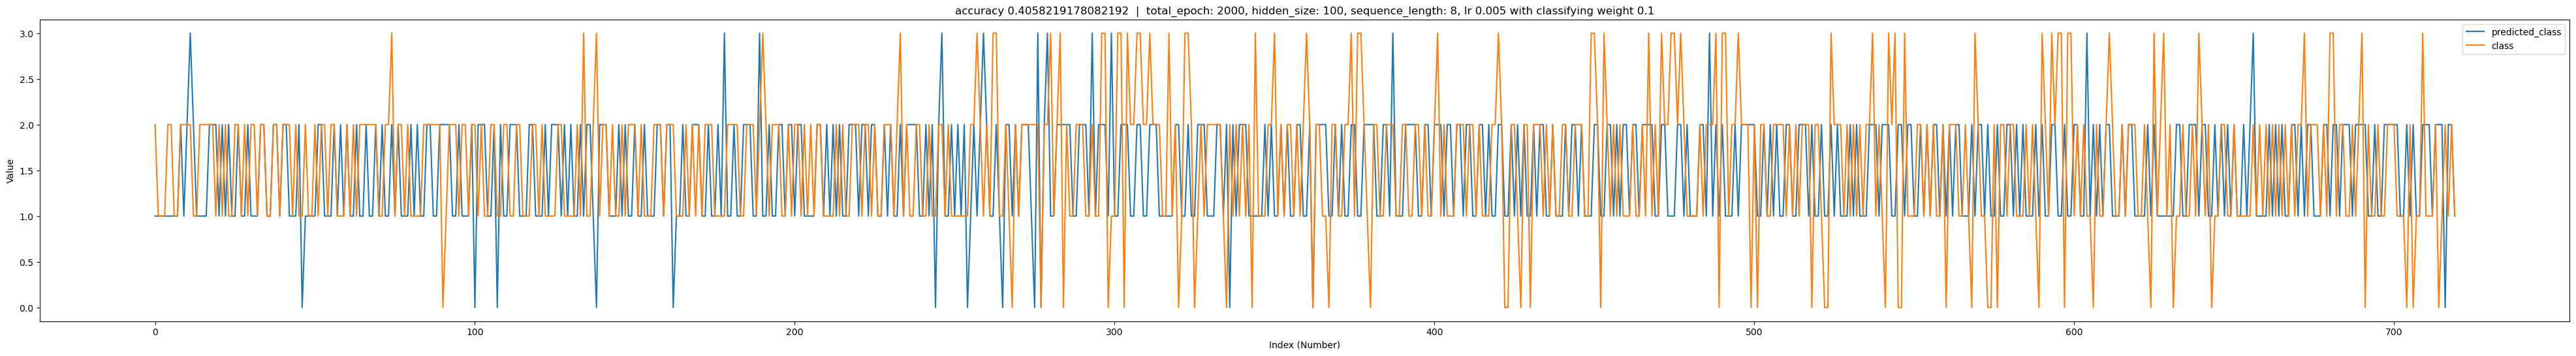

In [1306]:
prediction_df, accuracy = model_accuracy(model, X_train_tensor, output_train_df, output_scaler=output_scaler, doesPrint=True)
print(accuracy)

plt.figure(figsize=(50, 6))

def eda_result(offset = 0, length = len(y_train)):
    # prediction_df["class"] = prediction_df["class"].shift()
    eda_df = prediction_df[["predicted_class", "class"]][offset:min(len(y_train), offset+length)]
    eda_df.plot(kind="line", figsize=(50, 6))
    # plt.scatter(range(len(eda_y)), y=eda_y, color='#aaaaaa', s=10)
    # plt.scatter(range(len(eda_p)), y=eda_p,s=1)

eda_result(0*24, 30*24)

# 그래프 제목과 축 레이블 설정
plt.title(f'accuracy {accuracy}  |  total_epoch: {total_epoch}, hidden_size: {hidden_size}, sequence_length: {train_seq_len}, lr {optimizer.param_groups[0]["lr"]} with classifying weight {classify_weight}')
plt.xlabel('Index (Number)')
plt.ylabel('Value')

plt.show()

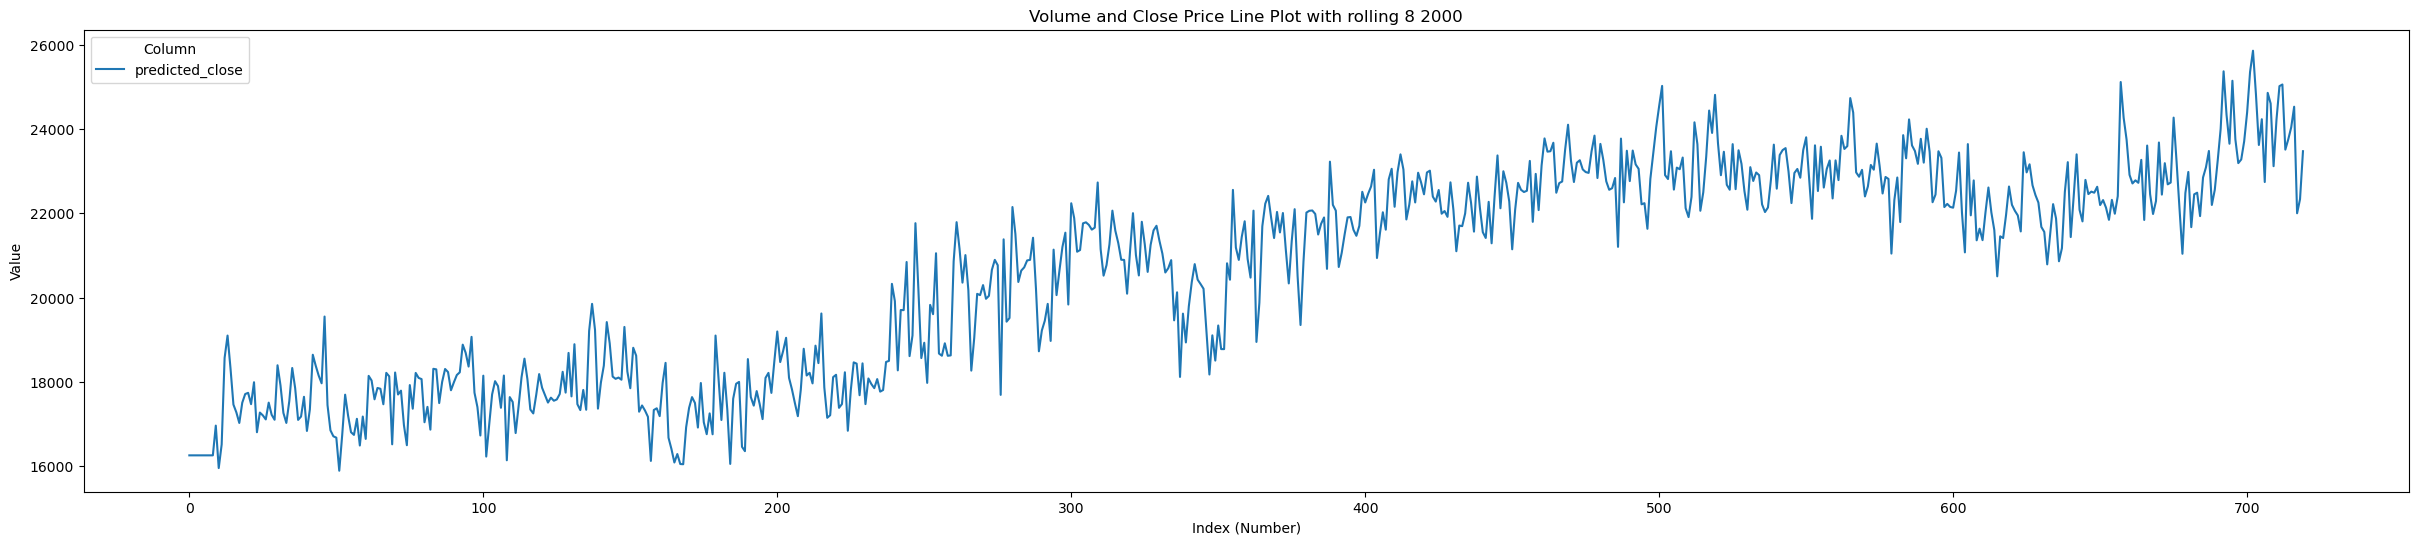

In [1307]:
eda_df = prediction_df[["predicted_close"]]
eda_df.reset_index(inplace=True)
df_melted = eda_df.melt(id_vars=['index'], var_name='Column', value_name='Value')

plt.figure(figsize=(30, 6))
sns.lineplot(x='index', y='Value', hue='Column', data=df_melted[:30*24])

# 그래프 제목과 축 레이블 설정
plt.title(f'Volume and Close Price Line Plot with rolling 8 {total_epoch}')
plt.xlabel('Index (Number)')
plt.ylabel('Value')

plt.show()

### Inference

In [1272]:
X_test, y_test, output_test = data_loader(test_df, mode="test", input_scaler=input_scaler, output_scaler=output_scaler, sequence_length=train_seq_len)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
output_test_df = pd.DataFrame(output_test, columns=["class"])

Number of sequences: 2784


In [1273]:
test_prediction_df, _ = model_accuracy(model, X_test_tensor, output_test_df, output_scaler=output_scaler)

submission_df = test_df[["ID", "target"]].copy()
submission_df["target"] = test_prediction_df["predicted_class"].values

                  0
count   2784.000000
mean   42228.082031
std     4176.178223
min    30607.878906
25%    41554.935547
50%    44376.138672
75%    44792.895508
max    45794.839844


In [1274]:
print(test_prediction_df[["predicted_class"]].value_counts().sort_index() / test_prediction_df.shape[0])

predicted_class
1                  0.498926
2                  0.501074
Name: count, dtype: float64


### Output File Save

In [1275]:
# output file 할당후 save 
submission_df.to_csv(f"output/output_{output_file_idx}_{accuracy:.4f}.csv", index=False)